In [12]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Data import

Import education data, filtering for rows which are only highschools that have grades 9, 10, 11, and 12.

In [13]:
school_data = pd.read_csv("data/CRDC 2015-16 School Data.csv", encoding = "ISO-8859-1")
school_layout = pd.read_csv("data/CRDC 2015-16 School Data Record Layout.csv", encoding = "ISO-8859-1")
school_data = school_data[school_data.SCH_GRADE_G09 =='Yes']
school_data = school_data[school_data.SCH_GRADE_G10 == 'Yes']
school_data = school_data[school_data.SCH_GRADE_G11 == 'Yes']
school_data = school_data[school_data.SCH_GRADE_G12 == 'Yes']
school_data = school_data[school_data.JJ == 'No']
school_data = school_data[(school_data.TOT_SATACT_M+school_data.TOT_SATACT_F)/(school_data['TOT_ENR_M'] + school_data['TOT_ENR_F'])<1]
school_data = school_data[school_data.SCH_SAL_TOTPERS_WFED>0]
len(school_data)
school_data.reset_index(drop=True,inplace=True)

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,6,23,24,25,30,31,1828) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


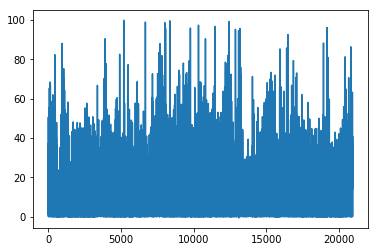

0

In [14]:
# SAT&ACT participation aggregate percent value

sat_data = school_data.iloc[: , 679:698]
test_participation = school_data['TOT_SATACT_M'] + school_data['TOT_SATACT_F']
school_population = school_data['TOT_ENR_M'] + school_data['TOT_ENR_F']
test_pop_percents = round(test_participation / school_population, 3) * 100
plt.plot(test_pop_percents)
plt.show()
len(test_pop_percents[test_pop_percents>100])

In [15]:
school_input_factors = pd.DataFrame()
school_input_factors['FUNDING_PER_STUDENT']=(school_data.SCH_SAL_TOTPERS_WFED+school_data.SCH_NPE_WFED) / (school_data.TOT_ENR_M + school_data.TOT_ENR_F)
school_input_factors['PERCENT_ENR_HI'] = (school_data.SCH_ENR_HI_M+school_data.SCH_ENR_HI_F)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)
school_input_factors['PERCENT_ENR_AM'] = (school_data.SCH_ENR_AM_M+school_data.SCH_ENR_AM_F+  school_data.SCH_ENR_HP_M+school_data.SCH_ENR_HP_F)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)
school_input_factors['PERCENT_ENR_AS'] = (school_data.SCH_ENR_AS_M+school_data.SCH_ENR_AS_F)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)
school_input_factors['PERCENT_ENR_BL'] = (school_data.SCH_ENR_BL_M+school_data.SCH_ENR_BL_F)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)
school_input_factors['PERCENT_ENR_WH'] = (school_data.SCH_ENR_WH_M+school_data.SCH_ENR_WH_F)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)
school_input_factors['PERCENT_ENR_TR'] = (school_data.SCH_ENR_TR_M+school_data.SCH_ENR_TR_F)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)
school_input_factors['CORP_PUNISH'] = (school_data.SCH_CORPINSTANCES_WODIS+school_data.SCH_CORPINSTANCES_WDIS)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)
school_input_factors['SCH_SIZE'] = (school_data.TOT_ENR_M + school_data.TOT_ENR_F)
school_input_factors['SUSPENSION'] = (school_data.SCH_OOSINSTANCES_WODIS+school_data.SCH_OOSINSTANCES_IDEA+school_data.SCH_OOSINSTANCES_504)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)
school_input_factors['EXPULSIONS'] = (school_data.TOT_DISCWODIS_EXPZT_M+school_data.TOT_DISCWODIS_EXPZT_F+school_data.SCH_DISCWODIS_EXPZT_LEP_M+school_data.SCH_DISCWODIS_EXPZT_LEP_F
)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)
school_input_factors['RETENSION'] = school_data.TOT_RET_G09_M+school_data.TOT_RET_G09_F+school_data.TOT_RET_G10_M+school_data.TOT_RET_G10_F+school_data.TOT_RET_G11_M+school_data.TOT_RET_G11_F+school_data.TOT_RET_G12_M+school_data.TOT_RET_G12_F
school_input_factors.RETENSION[school_input_factors.RETENSION<0] = 0
school_input_factors['CHARTER'] = school_data.SCH_STATUS_CHARTER.eq('Yes').mul(1)
school_input_factors.CORP_PUNISH[school_input_factors.CORP_PUNISH<0] = 0
school_input_factors['ENG_PROF'] = (school_data.TOT_LEPENR_M+school_data.TOT_LEPENR_F)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)



/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Regression Setup

In [16]:
def linear_regression(X, y):
    w, _, _, _ = np.linalg.lstsq(X, y, rcond=-1)
    return w

In [17]:
def fit_model(dfx, dfy, cols):
    # Note: this is might not really be a fair way to do a training / testing split
    # since it will result in instances that were very close in time falling in
    # both the training and testing set
    X_train, X_test, y_train, y_test = \
        train_test_split(dfx, dfy)

    model = LinearRegression()
    model.fit(X_train, y_train)
    for i, c in enumerate(cols):
      print('w_%d (the weight for %s) = %f' % (i+1, c, model.coef_[i]))
    
    print('w_%d (the weight for the bias term) = %f' % (len(cols) + 1, model.intercept_))

    print("\ny actual is within 5 of y predicted:")
    print('Accuracy on training set', (abs(model.predict(X_train) - y_train)<5).mean())
    print('Accuracy on testing set', (abs(model.predict(X_test) - y_test)<5).mean())
    print("\ny actual is within 10 of y predicted:")
    print('Accuracy on training set', (abs(model.predict(X_train) - y_train)<10).mean())
    print('Accuracy on testing set', (abs(model.predict(X_test) - y_test)<10).mean())
    return model

## Regression of School Success

In [18]:
# X_education = revs_total_1992.drop(columns=['STATE', 'AVG_MATH_8_SCORE'])
# y_education = revs_total_1992['AVG_MATH_8_SCORE']

# The columns we are inputting (the input)
X_experimental = school_input_factors #change assignent here

# The column(s) we are predicting (the output)
Y_experimental = test_pop_percents #change assignent here

In [19]:
X_experimental['bias'] = 1
# display the outputed weights to the input columns so that we can look
# at the calculated correlations relative to each input.
list(zip(linear_regression(X_experimental, Y_experimental), X_experimental.columns))

[(-5.9311270873931533e-06, 'FUNDING_PER_STUDENT'),
 (-1.5336549849059715, 'PERCENT_ENR_HI'),
 (4.8712044841086266, 'PERCENT_ENR_AM'),
 (19.126540477025976, 'PERCENT_ENR_AS'),
 (5.3559100529859007, 'PERCENT_ENR_BL'),
 (6.9307163483845109, 'PERCENT_ENR_WH'),
 (-23.676584681167203, 'PERCENT_ENR_TR'),
 (0.84806836722580625, 'CORP_PUNISH'),
 (0.0039261308376905557, 'SCH_SIZE'),
 (-0.26509648193755542, 'SUSPENSION'),
 (-0.40565046562985646, 'EXPULSIONS'),
 (-0.0033824879340534977, 'RETENSION'),
 (-4.6789287767011887, 'CHARTER'),
 (-6.0349534961462776, 'ENG_PROF'),
 (11.074131696445905, 'bias')]

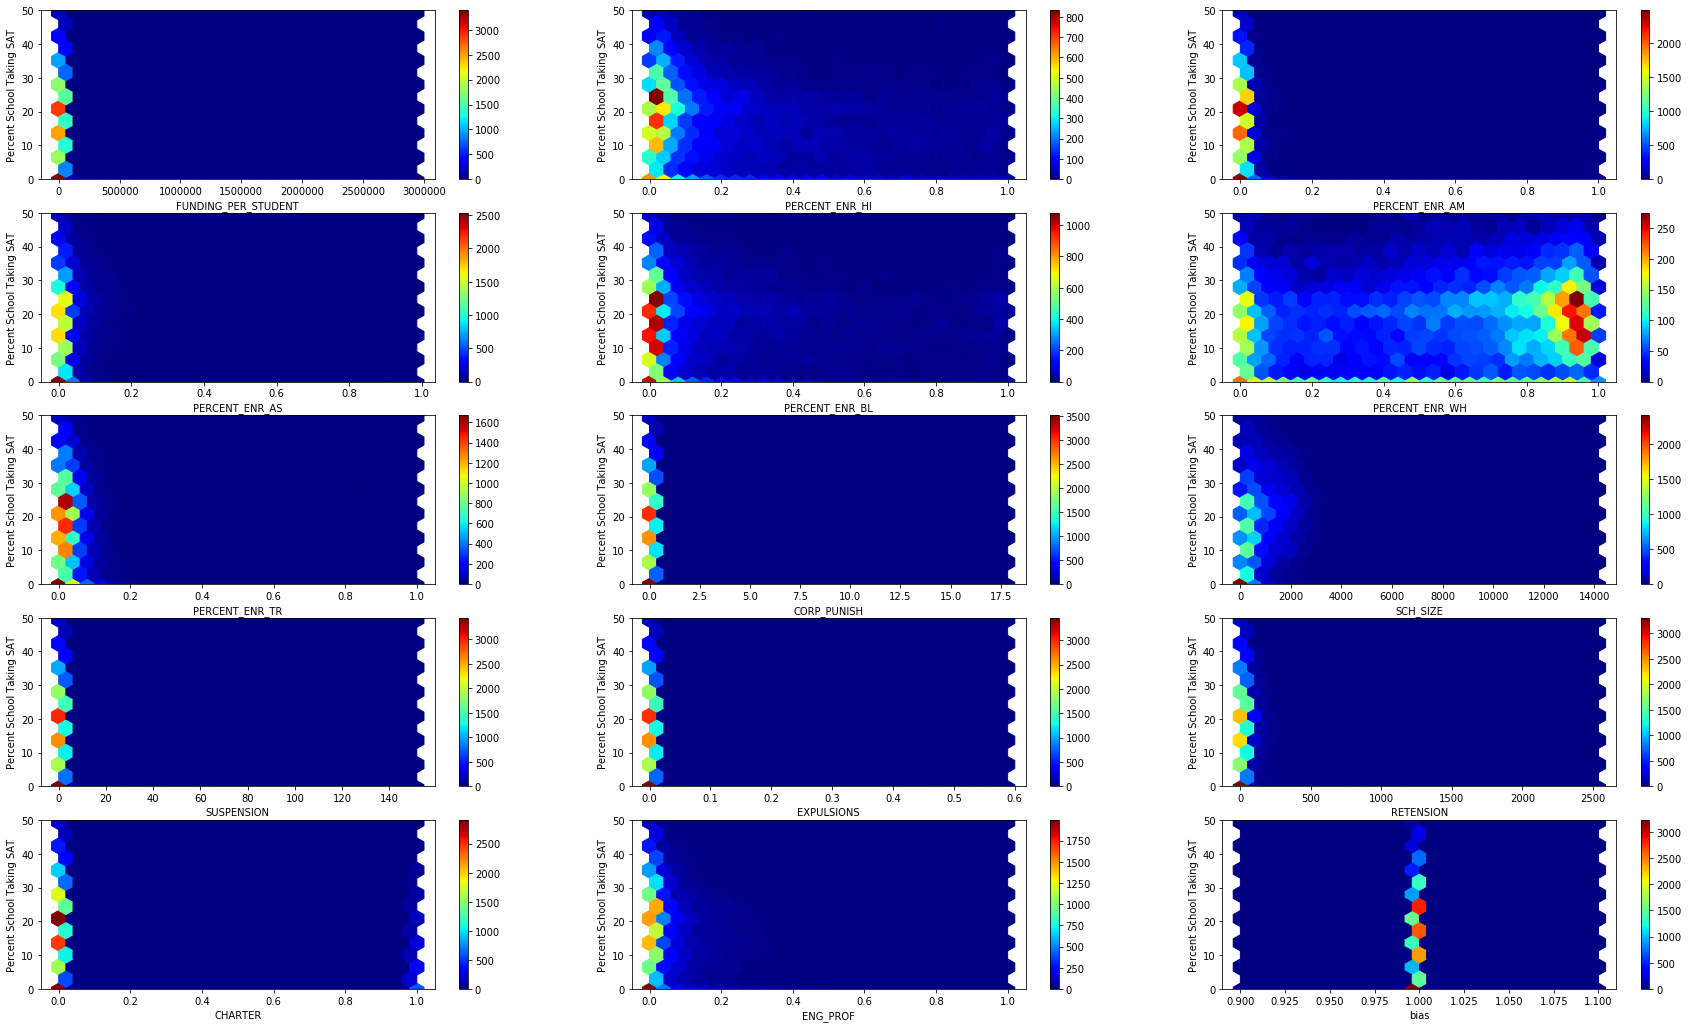

In [20]:
x_ed = X_experimental
y_ed = Y_experimental


plt.figure(figsize=(30, 18))
for idx, col in enumerate(x_ed):
    plt.subplot(5, 3, idx+1)
    plt.hexbin(x_ed[col], y_ed, gridsize=25, cmap='jet')
    plt.colorbar()
    plt.xlabel(col)
    plt.ylabel('Percent School Taking SAT')
    plt.ylim(0,50)

plt.subplots_adjust(wspace=.2)
plt.show()

In [21]:
print(min(school_data.SCH_SAL_TOTPERS_WFED.unique()))
print(min(school_data.SCH_NPE_WFED.unique()))
#school_data[X_experimental.FUNDING_PER_STUDENT == min(X_experimental.FUNDING_PER_STUDENT.unique())]

0.05
-5.0
